In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.6 MB/s eta 0:00:00:00:0100:01


In [19]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc

In [20]:
def load_full_df():
    main_df = pd.read_csv("processed_wildfire_ERA5_FWI.csv",index_col=0)
    main_df['date'] = pd.to_datetime(main_df['date'])
    main_df.rename(columns={'latitude_ERA5': 'latitude', 'longitude_ERA5': 'longitude'},inplace=True)
    unnamed_cols = [col for col in main_df.columns if col.startswith('Unnamed:')]
    main_df.drop(columns=unnamed_cols, inplace=True)
    main_df['type_of_high_vegetation'] = main_df['type_of_high_vegetation'].astype(int)
    main_df['type_of_low_vegetation'] = main_df['type_of_low_vegetation'].astype(int)
    return main_df

def test_train_validation_split(validation_df, test_train_df, target_variable='fire', test_proportion=0.33):
    """
    Validation data is obtained by taking all data after a certain time. This is similar to model deployment.
    Train and test data are obtained using a stratified split
    """
    X_validation = validation_df.drop(columns={target_variable})
    y_validation = validation_df[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(test_train_df.drop(columns={target_variable}), 
                                                        test_train_df[target_variable], 
                                                        test_size=test_proportion,
                                                        stratify=test_train_df[target_variable], 
                                                        random_state=42)
    
    return X_train, X_test, X_validation, y_train, y_test, y_validation

In [21]:
main_df = load_full_df()

# Create the validation dataframe out of data after 2019
validation_df = main_df[main_df['date'] > pd.Timestamp('2019-01-01')]
test_train_df = main_df[main_df['date'] < pd.Timestamp('2019-01-01')]

X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df, test_train_df, target_variable='fire', test_proportion=0.25)

In [22]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

# Define features to include #
pass_features = ['leaf_area_index_high_vegetation', 'slope_of_sub_gridscale_orography']
categorical_features = ['type_of_high_vegetation']
numeric_features = ['fire_count_past_10Days','DMC','global_noon_LST_2m_temperature','BUI',
                'FWI','latitude','FFMC','global_noon_LST_relative_humidity','24hr_max_temperature',
                'global_noon_LST_2m_temperature_1dayLag','global_noon_LST_2m_temperature_2dayLag',
                'high_vegetation_cover','24hr_max_temperature_1dayLag','low_vegetation_cover',
                '24hr_accumulated_precipitation']
####

# Define custom preprocessing functions. Put any custom functions in SVM_functions.py also so they are accessible by the ensemble
def extract_day_of_year(X):
    day_of_year = X['date'].dt.dayofyear.to_frame(name='day_of_the_year')
    return day_of_year

# Splitting the dataset into training and validation sets# Data Preprocessing Steps
date_transformer = ColumnTransformer(
    transformers=[
        ('date', FunctionTransformer(extract_day_of_year, validate=False), ['date'])
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
).set_output(transform='pandas')

scale = ColumnTransformer(
    transformers=[
        ('scale_transformer', StandardScaler(), numeric_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

cate = ColumnTransformer(
    transformers=[
        ('categorical_transformer', OneHotEncoder(sparse_output=False), categorical_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

pss = ColumnTransformer(
    transformers=[
        ('Pass_transformer', 'passthrough', pass_features)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

feature_union = FeatureUnion([
    ('numeric', scale),
    ('categorical', cate),
    ('pass', pss),
])

preprocessing_pipeline = Pipeline([
    ('day_of_year', date_transformer),
    ('feature_union', feature_union),
])

In [6]:
from joblib import dump
preprocessing_pipeline.fit(X_train)
dump(preprocessing_pipeline,'XGB_pipeline.joblib')

['XGB_pipeline.joblib']

In [16]:
# Pipeline Testing
#S1 = full_pipeline.named_steps['day_of_year'].fit_transform(X_train)
#S2 = full_pipeline.named_steps['feature_union'].fit_transform(S1)

In [23]:
# Apply preprocessing
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
X_validation_preprocessed = preprocessing_pipeline.transform(X_validation)

# Create DMatrix for train and validation sets
dtrain = xgb.DMatrix(X_train_preprocessed, label=y_train)
dtest = xgb.DMatrix(X_test_preprocessed, label=y_validation)
dvalidation = xgb.DMatrix(X_validation_preprocessed, label=y_validation)

XGBoostError: [16:38:28] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\data.cc:501: Check failed: this->labels.Size() % this->num_row_ == 0 (180371 vs. 0) : Incorrect size for labels.

In [11]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Define the parameter grid
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'num_boost_round': [200, 400, 800]
}

# Function to perform grid search with verbose output
def manual_grid_search(dtrain, param_grid, ratio, folds=5):
    best_auc = 0
    best_params = {}
    best_num_boost_round = 0  # Variable to store the best number of boosting rounds
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for num_boost_round in param_grid['num_boost_round']:
                params = {
                    'objective': 'binary:logistic',
                    'scale_pos_weight': ratio,
                    'eval_metric': 'logloss',
                    'tree_method': 'hist',
                    'device': 'cuda',
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                }
                # Perform k-fold cross validation
                cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=folds,
                                        metrics='auc', early_stopping_rounds=10, seed=42, verbose_eval=False)
                mean_auc = cv_results['test-auc-mean'].max()
                print(f"Mean AUC: {mean_auc} for params: {params}")
                if mean_auc > best_auc:
                    best_auc = mean_auc
                    best_params = params
                    best_num_boost_round = num_boost_round  # Update the best num_boost_round

    return best_params, best_auc, best_num_boost_round

# Calculate the ratio of negative to positive samples for scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Execute manual grid search
best_params, best_auc, best_num_boost_round = manual_grid_search(dtrain, param_grid, ratio)
print("Best parameters:", best_params)
print("Best cross-validation AUC: {:.2f}".format(best_auc))

# Train the final model with the best parameters and the optimal number of boosting rounds
final_model = xgb.train(best_params, dtrain, num_boost_round=best_num_boost_round)

#GS1
#Best parameters: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 5, 'learning_rate': 0.1, 'num_boost_round': 400}
#Best cross-validation AUC: 0.86

#GS2
#Best parameters: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 5, 'learning_rate': 0.1}
#Best cross-validation AUC: 0.86

Mean AUC: 0.8334274424033671 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 4, 'learning_rate': 0.01}
Mean AUC: 0.8426103089706369 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 4, 'learning_rate': 0.01}
Mean AUC: 0.8499177515246942 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 4, 'learning_rate': 0.01}
Mean AUC: 0.8591987480455284 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_metric': 'logloss', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 4, 'learning_rate': 0.1}
Mean AUC: 0.8627404131027527 for params: {'objective': 'binary:logistic', 'scale_pos_weight': 171.49972345132744, 'eval_m

In [7]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Calculate the ratio of negative to positive samples for scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

best_params = {
                'objective': 'binary:logistic',
                'scale_pos_weight': ratio,
                'eval_metric': 'logloss',
                'tree_method': 'hist',
                'device': 'cuda',
                'max_depth': 5,
                'learning_rate': 0.1,
            }

# Train the final model with the best parameters and the optimal number of boosting rounds
final_model = xgb.train(best_params, dtrain, num_boost_round=400)

In [9]:
# Optionally, you can save it to a JSON format (available in recent versions of XGBoost)
final_model.save_model('final_XGBoost.json')

In [24]:
import xgboost as xgb

# Load the model
loaded_model = xgb.Booster()
loaded_model.load_model('final_XGBoost.json')

In [25]:
# Predictions
dvalidation = xgb.DMatrix(X_validation_preprocessed, label=y_validation)

y_pred_proba = loaded_model.predict(dvalidation)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_validation, y_pred))

# Precision-Recall curve and AUC
precision, recall, thresholds = precision_recall_curve(y_validation, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    179619
           1       0.02      0.67      0.04       752

    accuracy                           0.87    180371
   macro avg       0.51      0.77      0.49    180371
weighted avg       0.99      0.87      0.93    180371

Precision-Recall AUC: 0.13511456742785022


Threshold: 0.95000000, TPR: 0.1330, FPR: 0.0015
Threshold: 0.72449446, TPR: 0.4000, FPR: 0.0374
Threshold: 0.56260210, TPR: 0.6000, FPR: 0.0965
Threshold: 0.45997974, TPR: 0.7000, FPR: 0.1450


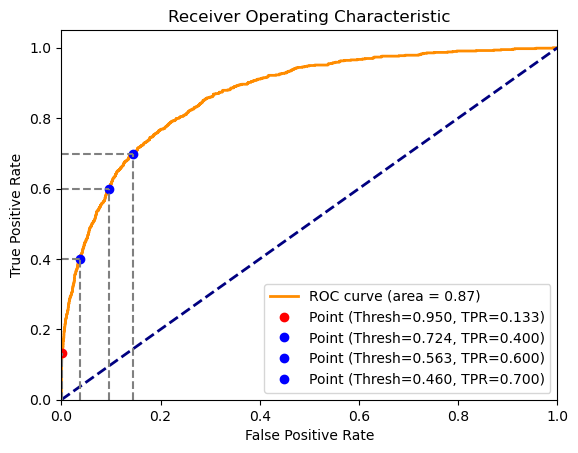

In [26]:
from Visualization_functions import plot_roc_curve

plot_roc_curve(y_validation,y_pred_proba,point_tprs=[0.4,0.6,0.7],point_thresholds=[0.95])

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict on the validation set
y_validation_pred = (y_pred_proba > 0.88).astype(int)

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_validation, y_validation_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_validation, y_validation_pred))
print(f'Precision: {precision_score(y_validation, y_validation_pred)}')
print(f'Recall: {recall_score(y_validation, y_validation_pred)}')

Validation set accuracy: 0.9896103032083872
f1 score:  0.14429223744292238
Precision: 0.10987482614742698
Recall: 0.21010638297872342


In [30]:
from Visualization_functions import generate_visualizations

generate_visualizations(X_validation,y_validation_pred,y_validation,main_df,"XGBoost_95thresh_Visuals")

In [29]:
import importlib
import Visualization_functions

importlib.reload(Visualization_functions)

<module 'Visualization_functions' from 'c:\\Users\\Chis\\Documents\\Python\\ML\\AI&ML_Course\\Final_Project\\Ensemble_model\\XGBoost\\Visualization_functions.py'>

In [13]:
import numpy as np
np.save("XGBoost_validation_proba.npy", y_pred_proba)

**Performance on test**

In [31]:
# Predictions
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)

y_pred_proba = loaded_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Precision-Recall curve and AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    826858
           1       0.02      0.74      0.04      4821

    accuracy                           0.81    831679
   macro avg       0.51      0.78      0.47    831679
weighted avg       0.99      0.81      0.89    831679

Precision-Recall AUC: 0.13694951873472397


Threshold: 0.95000000, TPR: 0.1504, FPR: 0.0021
Threshold: 0.78489071, TPR: 0.4000, FPR: 0.0338
Threshold: 0.62944627, TPR: 0.6000, FPR: 0.1020
Threshold: 0.54086548, TPR: 0.7000, FPR: 0.1581


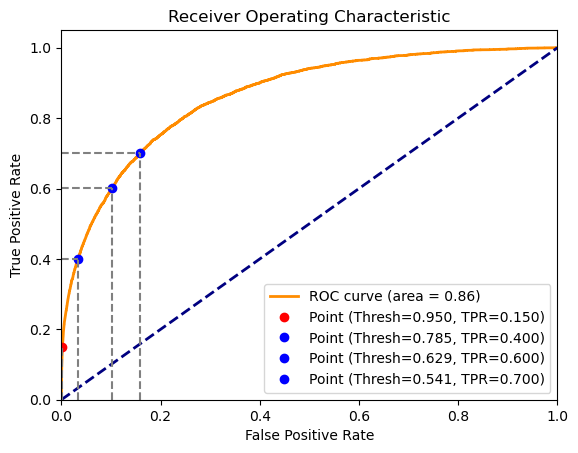

In [32]:
plot_roc_curve(y_test,y_pred_proba,point_tprs=[0.4,0.6,0.7],point_thresholds=[0.95])

In [29]:
import Visualization_functions as v
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import Normalize

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from sklearn.metrics import roc_curve, auc, confusion_matrix

y_pred = (y_pred_proba > 0.95).astype(int)
df = v.prepare_df_for_plotting(X_validation,y_pred,main_df)

all_coords = df[['latitude', 'longitude']].drop_duplicates()
all_coords['counts'] = 0

# Filter to include only incorrect predictions
incorrect_df = df[(df['result'] == 'FP') | (df['result'] == 'FN')]
incorrect_counts = incorrect_df.groupby(['latitude', 'longitude']).size().reset_index(name='counts_fn')

# Merge the counts back to all coordinates
agg_df = all_coords.merge(incorrect_counts, on=['latitude', 'longitude'], how='left')
agg_df['counts'] = agg_df['counts_fn'].fillna(0) + agg_df['counts']
agg_df.drop(columns=['counts_fn'], inplace=True)

# Plotting
fig = plt.figure(figsize=(40, 40))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-115, central_latitude=55))
ax.set_extent([-120, -110, 49, 60])  # Set geographic extent

# Add geographic features for context
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='black'), linestyle='-')

# Set the normalization of the colormap from 0 to 60
norm = Normalize(vmin=0, vmax=60)  # Here, you set the limits to 0 and 60
scatter = ax.scatter(agg_df['longitude'], agg_df['latitude'], c=agg_df['counts'], cmap='Reds', norm=norm, edgecolor='k', linewidth=0.5, alpha=0.7, s=600, transform=ccrs.PlateCarree())

# Create a colorbar and set its label
cbar = plt.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('Number of Incorrect Predictions', fontsize=40)
cbar.ax.tick_params(labelsize=30)

# Set the title and save the figure
plt.title('Incorrect Predictions Across Alberta', fontsize=40)
plt.savefig('XGB_adjusted_cmp.png')
plt.close(fig)